## BUSINESS PROBLEM

For this project, an attempt will be made to forecast the prices of the SP500 ETF (symbol "SPY"), based on the latest price movements of this index plus the latest prices of the 5 most important stocks that make up this index (Amazon, Google, Facebook, Apple and Microsoft). This project is not intended to be a fully developed investment strategy, but rather to present a first approximation of the use of Machine Learning techniques for time series forecasting.

In [325]:
# General libraries
import os
import time
import datetime
import pandas as pd
import math

# For data import
from alpha_vantage.timeseries import TimeSeries 

# For the FT
from numpy.fft import fft
import numpy as np

# For ploting

import matplotlib.pyplot as plt

# For ApacheSpark use
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType


## DATA ACQUISTION

The data for this project will be acquired from www.alphavantage.com. In order to use its datasets, is it necessary to get its API KEY, which allows us to get the prices information of most of the US Stocks. Due to this free API KEY only allows us to make 5 calls per minute, we need to make a loop calling for 5 stock prices every 60 seconds. 
This cell will get the intraday price information for the symbols we need, in 1 minute intervals. With this type of organized information, we won't need to quatisized this Time Series. Here is an Example:

In [326]:
keyID= '1J1ZO85W619SQ21V' 
ts = TimeSeries(keyID) #Object for data extraction
price_df,meta=ts.get_intraday(symbol='SPY',interval='1min',outputsize='full')
price_df


{'2020-05-13 13:45:00': {'1. open': '281.0050',
  '2. high': '281.3600',
  '3. low': '281.0000',
  '4. close': '281.2000',
  '5. volume': '160332'},
 '2020-05-13 13:44:00': {'1. open': '281.1300',
  '2. high': '281.1400',
  '3. low': '280.9400',
  '4. close': '281.0001',
  '5. volume': '97720'},
 '2020-05-13 13:43:00': {'1. open': '281.2700',
  '2. high': '281.2900',
  '3. low': '281.1300',
  '4. close': '281.1400',
  '5. volume': '48083'},
 '2020-05-13 13:42:00': {'1. open': '281.2500',
  '2. high': '281.3600',
  '3. low': '281.2100',
  '4. close': '281.2500',
  '5. volume': '168487'},
 '2020-05-13 13:41:00': {'1. open': '281.4600',
  '2. high': '281.6800',
  '3. low': '281.1700',
  '4. close': '281.2300',
  '5. volume': '142448'},
 '2020-05-13 13:40:00': {'1. open': '281.2400',
  '2. high': '281.4600',
  '3. low': '281.1301',
  '4. close': '281.4600',
  '5. volume': '73357'},
 '2020-05-13 13:39:00': {'1. open': '281.1600',
  '2. high': '281.4100',
  '3. low': '281.1300',
  '4. close'

We just realize that the price information comes in a OHLCV (open, high, low, close, volume) format, which is a pretty common format for this type of stock data. For the purposes of of this project, we will use just the close column, which represents the price at the end of the minute.
This data we also need it in a tabular way, so we will do it in the next cell.

In [327]:
list_stocks = ['FB', 'GOOG','AMZN','MSFT','AAPL']
prices_list=pd.DataFrame()
for activo in list_stocks:
    prices_dict,meta=ts.get_intraday(symbol=activo,interval='5min',outputsize='full')
    prices_df=pd.DataFrame(prices_dict)    
    prices_df=prices_df.transpose()
    prices_df.columns=['open','high','low',activo,'volume']
    price_list=prices_df[activo]

#     if len(price_list)>len_list:
        
#     elif len(price_list)<len_list:
#     elif len(price_list)==len_list:
#         pass
#     len_list=len(price_list)
    prices_list= pd.concat([prices_list,price_list],axis=1,sort=True)
    prices_list=prices_list.dropna()
time.sleep(60) #This is because the API KEY let me make only 5 calls per minute.

prices_dict,meta=ts.get_intraday(symbol='SPY',interval='5min',outputsize='full')
prices_df=pd.DataFrame(prices_dict)    
prices_df=prices_df.transpose()
prices_df.columns=['open','high','low','SPY','volume']
price_spyx=prices_df['SPY']
#     if len(price_list)>len_list:
        
#     elif len(price_list)<len_list:
#     elif len(price_list)==len_list:
#         pass
#     len_list=len(price_list)
prices_list= pd.concat([prices_list,price_spyx],axis=1,sort=True)
prices_list=prices_list.dropna()
prices_list=prices_list.astype(float)
#prices_list=prices_list.round(decimals=2)
    

In [328]:
prices_list.head()

,FB,GOOG,AMZN,MSFT,AAPL,SPY
2020-04-23 09:35:00,186.6400,1273.8328,2416.8816,174.945,277.75,281.60
2020-04-23 09:40:00,186.0600,1283.5100,2408.3887,174.425,277.91,282.00
2020-04-23 09:45:00,185.6900,1283.6600,2408.9900,174.610,278.61,281.94
2020-04-23 09:50:00,185.7990,1283.7000,2415.2251,174.550,278.27,281.63
2020-04-23 09:55:00,185.8174,1283.1200,2413.4050,174.140,278.12,281.21


## ETL

As the data extracted is already quantisized, I will just compute the returns of the prices. It means to divide the close price from one minute by the close price from the minute before.

### Returns computation

In [329]:
prices_returns=prices_list.pct_change()

In [330]:
prices_returns.head()

,FB,GOOG,AMZN,MSFT,AAPL,SPY
2020-04-23 09:35:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-23 09:40:00,-0.003108,0.007597,-0.003514,-0.002972,0.000576,0.001420
2020-04-23 09:45:00,-0.001989,0.000117,0.000250,0.001061,0.002519,-0.000213
2020-04-23 09:50:00,0.000587,0.000031,0.002588,-0.000344,-0.001220,-0.001100
2020-04-23 09:55:00,0.000099,-0.000452,-0.000754,-0.002349,-0.000539,-0.001491


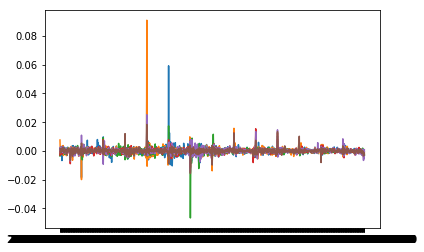

In [331]:
plt.plot(prices_returns)
plt.show()

As we can see on the figure above, there is some stationarity on the data, except from some points, so with this we can go on because it will allows to make later statistical analysis

Now we are going to discretize the points on the returns, assigning values from 0 for returns equal to 0, 1 for negative returns, and 2 for positive returns

In [332]:
for i in prices_returns.columns:
    for j in range(len(prices_returns[i])):
        if prices_returns[i].iloc[j] >0:
            prices_returns[i].iloc[j]=2
        elif prices_returns[i].iloc[j]<0:
            prices_returns[i].iloc[j]=1
        else:
            prices_returns[i].iloc[j]=0

In [333]:
prices_returns.head()

,FB,GOOG,AMZN,MSFT,AAPL,SPY
2020-04-23 09:35:00,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-23 09:40:00,1.0,2.0,1.0,1.0,2.0,2.0
2020-04-23 09:45:00,1.0,2.0,2.0,2.0,2.0,1.0
2020-04-23 09:50:00,2.0,2.0,2.0,1.0,1.0,1.0
2020-04-23 09:55:00,2.0,1.0,1.0,1.0,1.0,1.0


Then, as we will try to predict the returns of the 'SPY', it will be the 'label' input for later training. And as we want to know this returns for 1 timestep in the future, we are going to roll 1 timestep this feature

In [334]:
price_spy=price_spyx.iloc[2:].astype('float')

In [335]:
price_spy=price_spy.pct_change()

Now we are going to discretize this label values, but for returns over the 0.1% or below -0.1%
This is because we this model will be design for capital above 10k dollars , which 0.1% is equal to 10 dollars more than any trade-commission on any broker

In [336]:
for j in range(len(price_spy)):
    if price_spy.iloc[j] >=0.001:
        price_spy.iloc[j]=2
    elif price_spy.iloc[j]<=-0.001:
        price_spy.iloc[j]=1
    else:
        price_spy.iloc[j]=0

In [337]:
price_spy.rename('label',inplace=True).head()

2020-05-13 13:35:00    0.0
2020-05-13 13:30:00    2.0
2020-05-13 13:25:00    0.0
2020-05-13 13:20:00    2.0
2020-05-13 13:15:00    1.0
Name: label, dtype: float64

In [338]:
prices_returns_slice=prices_returns.iloc[1:-1]

In [339]:
prices_returns_final=pd.concat([prices_returns_slice,price_spy],axis=1,join='inner')

In [340]:
prices_returns_final.head()

,FB,GOOG,AMZN,MSFT,AAPL,SPY,label
2020-04-23 09:40:00,1.0,2.0,1.0,1.0,2.0,2.0,0.0
2020-04-23 09:45:00,1.0,2.0,2.0,2.0,2.0,1.0,2.0
2020-04-23 09:50:00,2.0,2.0,2.0,1.0,1.0,1.0,2.0
2020-04-23 09:55:00,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-04-23 10:00:00,1.0,1.0,2.0,2.0,2.0,2.0,0.0


So far, we made all the operations in a Pandas DataFrame, but now for ML purposes, we are going to made the next operations in a Apache Spark Dataset

In [341]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.getOrCreate()

In [342]:
prices_df=spark.createDataFrame(prices_returns_final)

In [343]:
prices_df.show(5)

+---+----+----+----+----+---+-----+
| FB|GOOG|AMZN|MSFT|AAPL|SPY|label|
+---+----+----+----+----+---+-----+
|1.0| 2.0| 1.0| 1.0| 2.0|2.0|  0.0|
|1.0| 2.0| 2.0| 2.0| 2.0|1.0|  2.0|
|2.0| 2.0| 2.0| 1.0| 1.0|1.0|  2.0|
|2.0| 1.0| 1.0| 1.0| 1.0|1.0|  1.0|
|1.0| 1.0| 2.0| 2.0| 2.0|2.0|  0.0|
+---+----+----+----+----+---+-----+
only showing top 5 rows



## MODEL DEFINITION, TRAINING, DEPLOYMENT AND EVALUATION

We are going to use the RandomForestClassifier for this project, computing vectors from our "x" features and making a final pipeline for the processes

In [344]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
input_columns=prices_df.schema.names[:-1]
result_col=prices_df.schema.names[-1]

df_train,df_test=prices_df.randomSplit([0.8,0.2])
#encoder=OneHotEncoder(inputCol="label",outputCol="labelVec")
vectorAssembler = VectorAssembler(inputCols=input_columns,outputCol="features")
rfc=RandomForestClassifier(numTrees=100)
pipeline=Pipeline(stages=[vectorAssembler,rfc])
model=pipeline.fit(df_train)


In [345]:
prediction = model.transform(df_test)

In [346]:
prediction.show()

+---+----+----+----+----+---+-----+--------------------+--------------------+--------------------+----------+
| FB|GOOG|AMZN|MSFT|AAPL|SPY|label|            features|       rawPrediction|         probability|prediction|
+---+----+----+----+----+---+-----+--------------------+--------------------+--------------------+----------+
|1.0| 1.0| 1.0| 1.0| 1.0|1.0|  0.0|[1.0,1.0,1.0,1.0,...|[63.3203758817449...|[0.63320375881744...|       0.0|
|1.0| 1.0| 1.0| 1.0| 1.0|1.0|  0.0|[1.0,1.0,1.0,1.0,...|[63.3203758817449...|[0.63320375881744...|       0.0|
|1.0| 1.0| 1.0| 1.0| 1.0|1.0|  0.0|[1.0,1.0,1.0,1.0,...|[63.3203758817449...|[0.63320375881744...|       0.0|
|1.0| 1.0| 1.0| 1.0| 1.0|1.0|  1.0|[1.0,1.0,1.0,1.0,...|[63.3203758817449...|[0.63320375881744...|       0.0|
|1.0| 1.0| 1.0| 1.0| 1.0|1.0|  1.0|[1.0,1.0,1.0,1.0,...|[63.3203758817449...|[0.63320375881744...|       0.0|
|1.0| 1.0| 1.0| 1.0| 1.0|1.0|  1.0|[1.0,1.0,1.0,1.0,...|[63.3203758817449...|[0.63320375881744...|       0.0|
|1.0| 1.0|

In [347]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("label")
    
binEval.evaluate(prediction) 

0.6571428571428571

This should be definitely improved! But for now we are going to move on

Now we will also compute this algorithm using scikit-learn

In [348]:
x=prices_returns_final[prices_returns_final.columns[:-1]]
y=prices_returns_final[prices_returns_final.columns[-1]]

In [349]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y)

In [350]:
len(x_train
   )

817

In [351]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier()
skmodel=rfc.fit(x_train,y_train)


In [352]:
prediction=skmodel.predict(x_test)

In [353]:
np.unique(prediction, return_counts=True)

(array([0., 1., 2.]), array([247,  15,  11], dtype=int64))

In [354]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,prediction)

0.652014652014652

Almost the same accuracy

Finally, we are going to make a Neural Network in order to compare both accuracies

In [355]:
from keras.preprocessing import sequence

In [356]:
from keras.layers import Dense
from keras.layers import Input,LSTM,Embedding,SpatialDropout1D
from keras.models import Model
import h5py

In [357]:
from keras.metrics import CategoricalAccuracy
from keras import metrics
from keras.models import Sequential

In [358]:
batch_size=32
timesteps=10
epochs=120

In [359]:
input_1_mae=Input(batch_shape=(batch_size,timesteps,len(prices_returns_final2.columns)-1))
lstm_1_mae=LSTM(8,stateful=True,return_sequences=True)(input_1_mae)
lstm_2_mae=LSTM(8,stateful=True,return_sequences=True)(lstm_1_mae)

output_1_mae=Dense(units=1)(lstm_2_mae)

classifier_mae=Model(inputs=input_1_mae,outputs=output_1_mae)

classifier_mae.compile(optimizer='adam',loss='mae')
classifier_mae.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (32, 10, 3)               0         
_________________________________________________________________
lstm_43 (LSTM)               (32, 10, 8)               384       
_________________________________________________________________
lstm_44 (LSTM)               (32, 10, 8)               544       
_________________________________________________________________
dense_23 (Dense)             (32, 10, 1)               9         
Total params: 937
Trainable params: 937
Non-trainable params: 0
_________________________________________________________________


In [360]:
def get_train_length(dataset,batch_size,test_percent):
    lenght=len(dataset)
    lenght*= 1- test_percent
    train_length_values=[]
    for x in range(int(lenght)-100,int(lenght)):
        modulo=x%batch_size
        if (modulo==0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))


In [361]:
length=get_train_length(prices_returns_final,batch_size,0.2)
print(length)

800
832
864
864


In [362]:
df_data_1_train=prices_returns_final[0:length]
training_set=df_data_1_train.iloc[:].values
training_set.shape

(864, 7)

In [363]:
x_train=[]
y_train=[]

for i in range(length):
    x_train.append(training_set[i,:len(prices_returns_final.columns)-1])
    y_train.append(training_set[i,-1])
len(x_train),len(y_train)

(864, 864)

In [364]:
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],1,len(prices_returns_final.columns)-1))
y_train=np.reshape(y_train,(y_train.shape[0],1,1))
x_train.shape,y_train.shape

((864, 1, 6), (864, 1, 1))

In [365]:
lag=len(prices_returns_final)-length

In [366]:
lag=int(lag/64)*64

In [367]:
lag=256

In [368]:
df_data_1_test=prices_returns_final[len(prices_returns_final)-lag:]
testing_set=df_data_1_test.iloc[:].values
testing_set.shape

(256, 7)

In [369]:
testing_value=testing_set[:,3]

In [370]:
x_test=[]
y_test=[]

for i in range(lag):
    x_test.append(testing_set[i,:len(prices_returns_final.columns)-1])
    y_test.append(testing_set[i,-1])
len(x_test),len(y_test)

(256, 256)

In [371]:
y_test

[0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 2.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 1.0,
 0.0,
 0.0,
 0.0,
 2.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 2.0,
 0.0,
 1.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0

In [372]:
x_test,y_test=np.array(x_test),np.array(y_test)
x_test=np.reshape(x_test,(x_test.shape[0],1,len(prices_returns_final.columns)-1))
y_test=np.reshape(y_test,(y_test.shape[0],1,1))
x_test.shape,y_test.shape

((256, 1, 6), (256, 1, 1))

In [373]:
x_test

array([[[2., 2., 1., 1., 2., 1.]],

       [[2., 2., 1., 2., 2., 2.]],

       [[1., 1., 2., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1.]]])

In [374]:
epochs=120

In [375]:
input_1_mae=Input(batch_shape=(batch_size,1,len(prices_returns_final.columns)-1))
lstm_1_mae=LSTM(512,stateful=True,return_sequences=True)(input_1_mae)
lstm_2_mae=LSTM(512,stateful=True,return_sequences=True)(lstm_1_mae)

output_1_mae=Dense(units=1)(lstm_2_mae)

classifier_mae=Model(inputs=input_1_mae,outputs=output_1_mae)

classifier_mae.compile(optimizer='adam',loss='mae',metrics=['acc'])
classifier_mae.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (32, 1, 6)                0         
_________________________________________________________________
lstm_45 (LSTM)               (32, 1, 512)              1062912   
_________________________________________________________________
lstm_46 (LSTM)               (32, 1, 512)              2099200   
_________________________________________________________________
dense_24 (Dense)             (32, 1, 1)                513       
Total params: 3,162,625
Trainable params: 3,162,625
Non-trainable params: 0
_________________________________________________________________


In [376]:
def lstmModel():
    input_1_mae=Input(batch_shape=(batch_size,1,len(prices_returns_final.columns)-1))
    lstm_1_mae=LSTM(128,stateful=True,return_sequences=True)(input_1_mae)
    lstm_2_mae=LSTM(128,stateful=True,return_sequences=True)(lstm_1_mae)

    output_1_mae=Dense(units=1)(lstm_2_mae)

    classifier_mae=Model(inputs=input_1_mae,outputs=output_1_mae)

    classifier_mae.compile(optimizer='adam',loss='mae',metrics=['acc'])
    return classifier_mae

In [377]:
model=lstmModel()

In [378]:
model.fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size
)

Epoch 1/120
864/864 [==============================] - 1s 2ms/step - loss: 0.6348 - acc: 0.4699
Epoch 2/120
864/864 [==============================] - 0s 179us/step - loss: 0.6676 - acc: 0.5255
Epoch 3/120
864/864 [==============================] - 0s 178us/step - loss: 0.5802 - acc: 0.6319
Epoch 4/120
864/864 [==============================] - 0s 222us/step - loss: 0.5611 - acc: 0.6319
Epoch 5/120
864/864 [==============================] - 0s 188us/step - loss: 0.5486 - acc: 0.6319
Epoch 6/120
864/864 [==============================] - 0s 186us/step - loss: 0.5456 - acc: 0.6319
Epoch 7/120
864/864 [==============================] - 0s 182us/step - loss: 0.5448 - acc: 0.6319
Epoch 8/120
864/864 [==============================] - 0s 196us/step - loss: 0.5446 - acc: 0.6319
Epoch 9/120
864/864 [==============================] - 0s 195us/step - loss: 0.5469 - acc: 0.6319
Epoch 10/120
864/864 [==============================] - 0s 192us/step - loss: 0.5455 - acc: 0.6319
Epoch 11/120
864/864 

864/864 [==============================] - 0s 176us/step - loss: 0.5431 - acc: 0.6319
Epoch 84/120
864/864 [==============================] - 0s 181us/step - loss: 0.5432 - acc: 0.6319
Epoch 85/120
864/864 [==============================] - 0s 180us/step - loss: 0.5433 - acc: 0.6319
Epoch 86/120
864/864 [==============================] - 0s 171us/step - loss: 0.5433 - acc: 0.6319
Epoch 87/120
864/864 [==============================] - 0s 178us/step - loss: 0.5431 - acc: 0.6319
Epoch 88/120
864/864 [==============================] - 0s 177us/step - loss: 0.5430 - acc: 0.6319
Epoch 89/120
864/864 [==============================] - 0s 176us/step - loss: 0.5433 - acc: 0.6319
Epoch 90/120
864/864 [==============================] - 0s 186us/step - loss: 0.5431 - acc: 0.6319
Epoch 91/120
864/864 [==============================] - 0s 174us/step - loss: 0.5431 - acc: 0.6319
Epoch 92/120
864/864 [==============================] - 0s 175us/step - loss: 0.5431 - acc: 0.6319
Epoch 93/120
864/864 [=

In [379]:
y_pred=model.predict(x_test)
y_pred

array([[[0.00088198]],

       [[0.00081804]],

       [[0.00125892]],

       [[0.00126022]],

       [[0.00088574]],

       [[0.00061427]],

       [[0.0006597 ]],

       [[0.00113639]],

       [[0.00114415]],

       [[0.00130292]],

       [[0.00161776]],

       [[0.00098303]],

       [[0.0011534 ]],

       [[0.00113115]],

       [[0.00126219]],

       [[0.00085786]],

       [[0.00127452]],

       [[0.00020794]],

       [[0.00138743]],

       [[0.00140901]],

       [[0.00112575]],

       [[0.00065318]],

       [[0.00075643]],

       [[0.00062495]],

       [[0.0009226 ]],

       [[0.00136367]],

       [[0.00132823]],

       [[0.00128998]],

       [[0.00166276]],

       [[0.00085122]],

       [[0.00084803]],

       [[0.00072724]],

       [[0.00114678]],

       [[0.00122744]],

       [[0.00095865]],

       [[0.00098909]],

       [[0.00081289]],

       [[0.00101205]],

       [[0.00121824]],

       [[0.00124853]],

       [[0.00113748]],

       [[0.00123

In [380]:
accr = model.evaluate(x_test,y_test)


256/256 [==============================] - 0s 479us/step


In [381]:
accr

[0.41853306721895933, 0.734375]

As we can see, this neural network, for this purposes, is working better than the ML algorithm